In [1]:
# Import Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
# Import Data
def load_dataset(fileName):
    allData = pd.read_csv('./' + fileName)
    return allData

In [3]:
# Clean and preprocess data
def clean_data(dataX, dataY, vocab_size, max_len, test_size):
    # Split data into train and test data
    trainX, testX, trainY, testY = train_test_split(dataX,dataY, test_size = test_size, random_state=0)

    trainX = np.array(trainX.tolist())
    trainY = np.array(trainY.tolist())
    testX = np.array(testX.tolist())
    testY = np.array(testY.tolist())

    # Create text tokenizer
    oov_tok = "<OOV>"
    padding_type = 'post'
    trunc_type='post'
    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(trainX)
    word_index = tokenizer.word_index

    # pads each sentence - all have to be same length for neural network input
    train_sequences = tokenizer.texts_to_sequences(trainX)
    train_padded = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

    test_sequences = tokenizer.texts_to_sequences(testX)
    test_padded = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating = trunc_type)

    trainY = pd.get_dummies(trainY).values
    testY = pd.get_dummies(testY).values


    return train_padded, test_padded, trainY, testY
    

In [4]:
def define_model_tensorflow(vocab_size, max_length):
    embedding_dim = 300
    model = Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(21, activation='softmax')
    ])

    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
# model evaluation
def evaluate_model(model, train_padded, trainY, test_padded, testY, num_epochs):
    verbose = 1
    scores, histories = list(), list()

    history = model.fit(train_padded, trainY, epochs=num_epochs, validation_data=(test_padded,testY), verbose = verbose)
    # evaluate model performance
    _, acc = model.evaluate(test_padded, testY, verbose=1)
    print ('> %.3f' % (acc * 100.0))

    scores.append(acc)
    histories.append(history)

    return scores, histories


In [6]:
# present results
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        #plot loss 
        plt.subplot(2,1,1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        plt.legend()
        # plot accuracy
        plt.subplot(2,1,2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        plt.legend()
    plt.show()

In [7]:
# Load in Data
allData = load_dataset('train.csv')
# allData['categories'].value_counts().plot(kind='bar', figsize=(14,5))

# set model parameters
vocab_size = 5000 # max vocab size
max_len = 100 # sequenece length to pad the outputs to

# Clean/preprocess data
train_padded, test_padded, trainY, testY = clean_data(allData['title'] + ' ' + allData['description'], allData['categories'], vocab_size, max_len, test_size = 0.3)



In [8]:
model = define_model_tensorflow(vocab_size, max_len)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          1500000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 200)               1

In [9]:
scores, histories = evaluate_model(model, train_padded, trainY, test_padded, testY, num_epochs = 10)

Epoch 1/10
1012/1012 [==============================] - 352s 340ms/step - loss: 2.6230 - accuracy: 0.1597 - val_loss: 2.1907 - val_accuracy: 0.2656
Epoch 2/10
1012/1012 [==============================] - 329s 325ms/step - loss: 2.5719 - accuracy: 0.1806 - val_loss: 2.1784 - val_accuracy: 0.2748
Epoch 3/10
1012/1012 [==============================] - 375s 370ms/step - loss: 1.8519 - accuracy: 0.3684 - val_loss: 1.4734 - val_accuracy: 0.5264
Epoch 4/10
1012/1012 [==============================] - 352s 348ms/step - loss: 1.2177 - accuracy: 0.6049 - val_loss: 1.1007 - val_accuracy: 0.6596
Epoch 5/10
1012/1012 [==============================] - 341s 337ms/step - loss: 0.9258 - accuracy: 0.7103 - val_loss: 1.0633 - val_accuracy: 0.6815
Epoch 6/10
1012/1012 [==============================] - 341s 337ms/step - loss: 0.7813 - accuracy: 0.7615 - val_loss: 1.0059 - val_accuracy: 0.7150
Epoch 7/10
1012/1012 [==============================] - 303s 299ms/step - loss: 0.6757 - accuracy: 0.7941 - val_

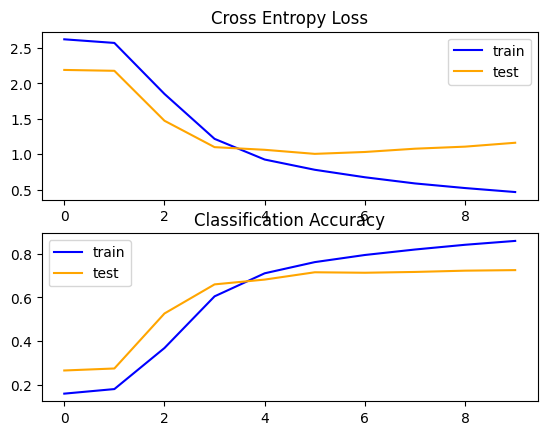

In [10]:
summarize_diagnostics(histories)

434/434 [==============================] - 13s 30ms/step


Text(0.5, 135.7222222222222, 'Predicted label')

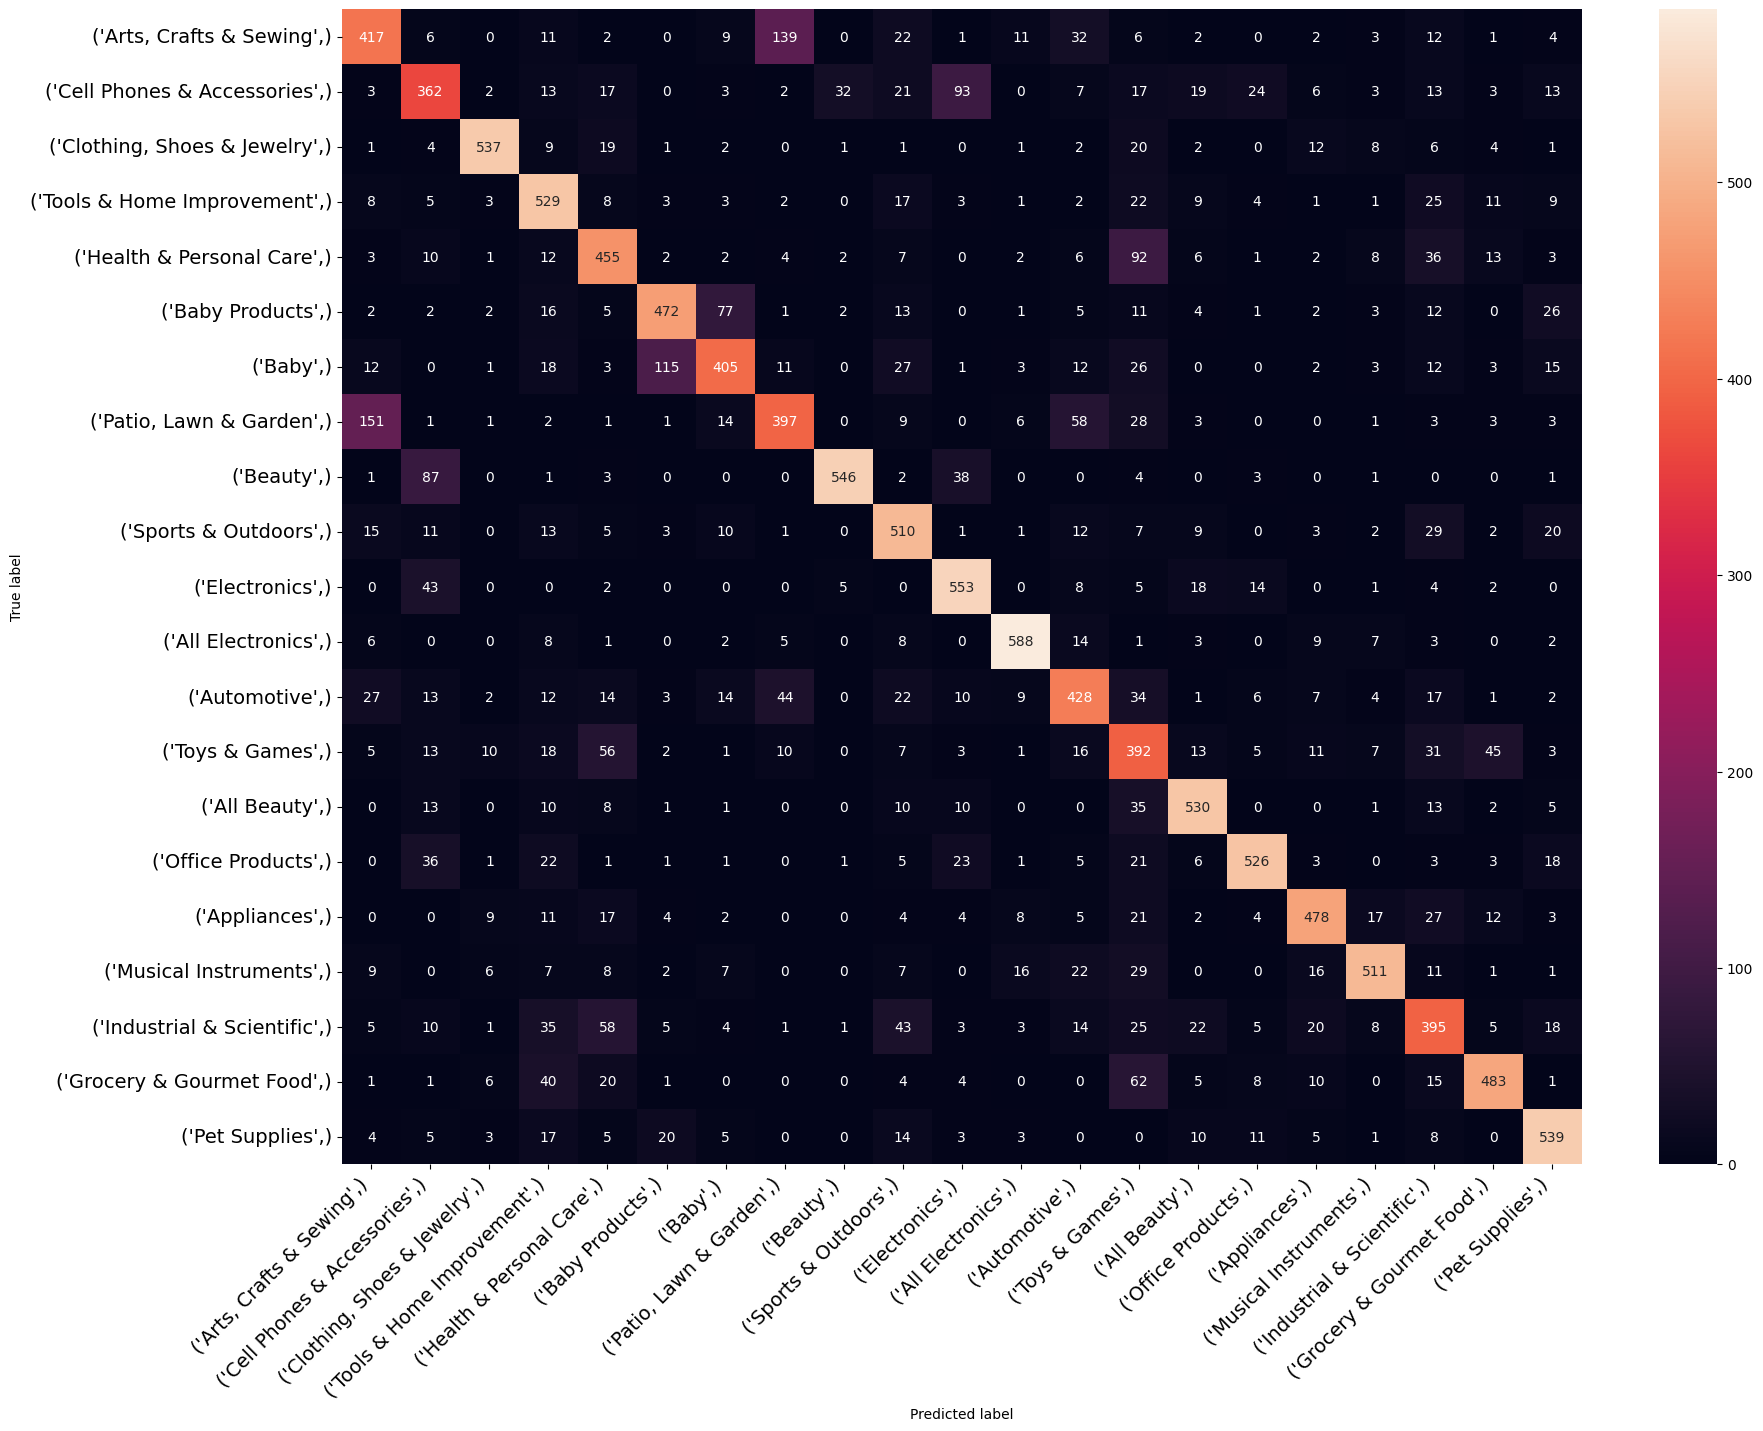

In [11]:
# Plot test data confusion Matrix
predictions = model.predict(test_padded, verbose=1)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(testY, axis = 1)

cm = confusion_matrix(y_test, classes)

all_cat = pd.DataFrame(allData['categories']).drop_duplicates(ignore_index=True)

df_cm = pd.DataFrame(cm, index=all_cat, columns=all_cat)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [31]:
# Check test data
data_test = load_dataset('train.csv')
data_test = data_test[:1000]
data_test_x = list(data_test['title'] + ' ' + data_test['description'])
data_test_x = np.array(data_test_x)
   
# Create text tokenizer
oov_tok = "<OOV>"
padding_type = 'post'
trunc_type='post'
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data_test_x)
word_index = tokenizer.word_index

# pads each sentence - all have to be same length for neural network input
train_sequences = tokenizer.texts_to_sequences(data_test_x)
data_test_padded = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

data_test_y = pd.get_dummies(np.array(list(data_test['categories']))).values


In [32]:
pred = model.predict(data_test_padded, verbose = 1)
test_classes = np.argmax(pred, axis = 1)
actual_classes = np.argmax(data_test_y, axis = 1)

32/32 [==============================] - 1s 42ms/step


In [34]:
# Create submission file - test results
results_df = data_test.assign(categories_id=test_classes)
results_df = results_df.assign(categories_actual_id=actual_classes)
# all_cat['categories_id'] = all_cat.index
# results_df = pd.merge(results_df, all_cat, how='left', on=['categories_id'])

results_df.to_csv('submission.csv')

    


In [38]:
data_test_padded[:10]

array([[3594, 3595, 1118,    8,  201, 3595, 1118,    7,    1,   33,    1,
        3595,   52,  350, 1029,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [1829,  227,    1,  202,  963,    7,  554,    1,  125,   26,  202,
           3,  125,   26,  157,    5,  369,  607, 3596,   15,  110, 1444,
         314,    1,  110,   70,   10,    4,  113,    6,   95,  206,  202,
        3597,   70,    4, 4736,   20,  259,  158,   46,   20,   17,   27,
          46,    1,  46